<a href="https://colab.research.google.com/github/Noureddineidir/ML-4-Finance/blob/main/Deep_PDEs_Greeks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Parametric PDE for Two Assets



Nous reprenons le travail proposé par Linus Wunderlich, 2020 et Kathrin Glau. Leur travaux sont mis a disposition dans le lien git ci-dessous.

[https://github.com/LWunderlich/DeepPDE]

Pour exploiter notre notebook à son plein potentiel, nous recommandons de l'ouvrir sur Colab.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Noureddineidir/Applied-ML-ENSAE-Course-/blob/main/Deep_PDEs_Greeks.ipynb)

Les auteurs proposent notamment une application de leur modèle entrainé par leur méthode Deep PDE avec deux actifs sous-jacents dans le modèle de Black-Scholes. Nous reprenons notamment leur code de pricer de référence et d'architecture, tels que nous les présentons dans le rapport. Nous proposons également de constuire les figures que les auteurs ont mis à disposition dans la présentation de leur résultats. A ces élements, nous ajoutons l'implémentation d'une **évaluation du modèle par la volatilité implicite** ainsi que l'**étude des sensibilités**. Cette dernière partie consiste à la fois l'étude de la **sensibilité du modèle original** que l'implémentation de la **modification de la fonction de perte**.

## Utilisation: 
Ce notebook permet de charger le modèle entrainé dans le cadre de l'article de recherche (lorsque load_model==True) ou alors d'entrainer un réseau plus petit. Nous proposons notamment d'entrainer un réseau sur deux actif sous-jacents selon la même approche que celle proposée par les auteurs en réduisant fortement la taille du réseau : ici 3 couches de 90 neurones (au lieu de 9).

Nous proposons alors dans notre approche d'approfondir l'étude des sensibilités et plus particulièrement du delta de l'option vis-à-vis d'un sous-jacent. 


### Intérêt de colab:
L'usage de colab est recommandé pour l'entrainement d'un modèle, afin de bénéficier des sessions GPU.


## Formulation du problème
Le prix de l'option u résout l'équation différentielle partielle multivariée de Black-Scholes (formulée en log prix, t étant le temps à l'échéance) :

$
\partial_t u + 
  r  u 
  -   \left(r-\frac{\sigma_1^2}{2}\right)\partial_{x_1} u 
  - \left(r-\frac{\sigma_2^2}{2}\right)\partial_{x_2} u 
  -  \frac{\sigma_1^2}{2}  \, \partial_{x_1x_1} u  
  - \frac{\sigma_2^2}{2}  \, \partial_{x_2x_2} u  
  -  \rho \sigma_1 \sigma_2 \, \partial_{x_1x_2} u = 0
$

avec le payoff initial : 

$
u(t=0) = \max(0, (e^{x_1} + e^{x_2})/2 - K).
$

Les auteurs soulèvent que nous pouvons reformuler n'importe quelle option comme une option avec un prix d'exercice K=100$, donc nous le gardons fixe.  



 ## Deep Parametric PDE Method

La méthode des deep parametric PDEs entraîne un réseau neuronal de manière non supervisée pour approximer le prix de l'option pour toutes les valeurs de $t$, $x$ et les paramètres de l'option $r, \sigma_1, \sigma_2, \rho$ (rassemblés dans le vecteur de paramètres $\mu$) et nous obtenons alors en sortie :
$u_{\rm{DNN}}(t, x, \mu) \approx  u(t, x, \mu)$.

L'apprentissage est non supervisé car la fonction de perte est purement basée sur l'EDP.

In [1]:
!pip install tensorflow==2.3.0 #package used for training the paper model

     |████████████████████████████████| 320.4 MB 49 kB/s 
     |████████████████████████████████| 459 kB 41.0 MB/s 
     |████████████████████████████████| 20.1 MB 12.1 MB/s 
     |████████████████████████████████| 2.9 MB 29.8 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.0
    Uninstalling tensorflow-2.8.0:


In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import math 

from tensorflow import keras
from scipy.stats import norm
from numpy.polynomial.hermite import hermgauss

import matplotlib.pyplot as plt

import urllib
import os

np.random.seed(42)

## Paramètres de l'utilisateur
Ces paramètres peuvent être changés sans entrainer à nouveau le modèle.

* load_model : 
Si True, le modèle pré-entraîné utilisé dans l'article sera téléchargé et chargé. Si False, un réseau plus petit sera créé et entraîné. Les résultats seront légèrement moins précis pour permettre un temps d'entraînement raisonnable.
 * nr_samples_surface_plot : Nombres de points dans chaque direction utilisés pour les graphiques de surface variant les prix des actifs des sous-jacents.
 * nr_samples_scatter_plot : Nombre de points aléatoires (variant le temps, le prix de l'actif et les paramètres de l'option) utilisés pour les diagrammes de dispersion ci-dessous.
 * nr_samples_error_calculation : Nombre de points aléatoires utilisés ci-dessous pour approximer l'erreur $L^2$ et $L^\infty$ de la méthode deep PDE.

In [2]:
load_model = False
nr_samples_surface_plot = 21
nr_samples_scatter_plot = 1000
nr_samples_error_calculation = 10000

## Paramètres du modèle
Attention après toute modification, le modèle doit être entrainé à nouveau.

In [3]:
# Model parameters. Re-train model after any changes.
s_min_interest = 25
s_max_interest = 150
t_min_interest = 0.5
t_max_interest = 4.

riskfree_rate_min = 0.1
riskfree_rate_max = 0.3
riskfree_rate_eval = 0.2

volatility_min = 0.1
volatility_max = 0.3
volatility1_eval = 0.1
volatility2_eval = 0.3

correlation_min = 0.2
correlation_max = 0.8
correlation_eval = 0.5

strike_price = 100.

## Paramètres internes
Les auteurs indiquent que ces variables ne doivent pas être modifiées, sauf si vous envisagez d'adapter le code à de nouvelles situations. Nous les gardons ainsi comme telles mais rappelons qu'il s'agit d'une partie à modifier, dans le cas où l'on envisagerait de pricer une option sur 3 actifs sous-jacents par exemples.

In [4]:
dimension_state = 2
dimension_parameter = 4
dimension_total = 1 + dimension_state + dimension_parameter

t_min = 0.
t_max = t_max_interest
s_max = strike_price * (1 + 3*volatility_max*t_max)
x_max = np.log(s_max)
x_min = 2*np.log(strike_price) - x_max

normalised_max = 1
normalised_min = -1

def transform_ab_to_cd(x, a, b, c, d): 
    """
    Perform a linear transformation of a scalar from the souce interval
    to the target interval.

    Keyword arguments:
    x -- scalar point(s) to transform
    a, b -- interval to transform from
    c, d -- interval to transform to 
    """
    return c + (x-a) * (d-c) / (b-a)

def transform_to_logprice(x): 
    """ Transform normalised variable to the log-price. """
    return transform_ab_to_cd(x, normalised_min, normalised_max, x_min, x_max)

def transform_to_time(t): 
    """ Transform normalised variable to the time variable. """
    return transform_ab_to_cd(t, normalised_min, normalised_max, t_min, t_max)

def normalise_logprice(x):
    """ Transform log-price to its corresponding normalised variable. """
    return transform_ab_to_cd(x, x_min, x_max, normalised_min, normalised_max)

def normalise_time(t): 
    """ Transform time to its corresponding normalised variable. """
    return transform_ab_to_cd(t, t_min, t_max, normalised_min, normalised_max)

t_min_interest_normalised = normalise_time(t_min_interest)
t_max_interest_normalised = normalise_time(t_max_interest)

diff_dx = (normalised_max-normalised_min) / (x_max-x_min) 
diff_dt = (normalised_max-normalised_min) / (t_max-t_min)

def transform_to_riskfree_rate(mu_1):
    """ Transform normalised variable to the risk-free rate. """
    return transform_ab_to_cd(mu_1, normalised_min, normalised_max,
                                    riskfree_rate_min, riskfree_rate_max)

def transform_to_volatility(mu_2):
    """ Transform normalised variable to the volatility. """
    return transform_ab_to_cd(mu_2, normalised_min, normalised_max,
                                    volatility_min, volatility_max)
    
def transform_to_correlation(mu_3):
    """ Transform normalised variable to the correlation. """
    return transform_ab_to_cd(mu_3, normalised_min, normalised_max,
                                    correlation_min, correlation_max)

def normalise_riskfree_rate(riskfree_rate):
    """ Transform risk-free rate to its corresponding normalised variable. """
    return transform_ab_to_cd(riskfree_rate,
                              riskfree_rate_min, riskfree_rate_max, 
                              normalised_min, normalised_max)
    
def normalise_volatility(volatility):
    """ Transform volatility to its corresponding normalised variable. """
    return transform_ab_to_cd( volatility, volatility_min, volatility_max,
                                            normalised_min, normalised_max)
    
def normalise_correlation(correlation):
    """ Transform correlation to its corresponding normalised variable. """
    return transform_ab_to_cd(correlation, correlation_min, correlation_max,
                                            normalised_min, normalised_max)


riskfree_rate_eval_normalised = normalise_riskfree_rate(riskfree_rate_eval)
volatility1_eval_normalised = normalise_volatility(volatility1_eval)
volatility2_eval_normalised = normalise_volatility(volatility2_eval)
correlation_eval_normalised = normalise_correlation(correlation_eval)

## Fonctions pour l'évaluation
Dans cette section, nous rassemblons quelques fonctions utilisées par les auteurs pour évaluer la méthode deep PDE. Ceci inclut un pricer de référence et des évaluations de fonctions aléatoires.
Nous ajoutons à cela nos fonctions d'éavluation des sensibilités afin d'étudier l'impact de la nouvelle fonction de perte sur l'approximation tant du prix de l'option que de son delta par rapport au premier actif sous-jacent. 

### Solution exacte (par les auteurs)
Calcule la solution exacte par une intégrale 1D du payoff lissé en utilisant les méthodes de Bayer, et al (2018) and Pötz (2020).

Bayer, C., Siebenmorgen, M. & Tempone, R. (2018), Smoothing the payoff for efficient computation of basket option prices, Quantitative Finance 18(3), 491–505.

Pötz,C.(2020), Function approximation for option pricing and risk management,
PhD thesis, Queen Mary University of London.


In [5]:
def decompose_covariance_matrix(t, volatility1, volatility2, correlation):
    """ Decompose covariance matrix as in Lemma 3.1 of Bayer et. al (2018). """
    sigma_det = (1-correlation**2) * volatility1**2 * volatility2**2
    sigma_sum = (volatility1**2 + volatility2**2 
                  - 2*correlation*volatility1*volatility2)

    ev1 = volatility1**2 - correlation*volatility1*volatility2
    ev2 = -(volatility2**2 - correlation*volatility1*volatility2)
    ev_norm = np.sqrt(ev1**2 + ev2**2)

    eigenvalue = volatility1**2 + volatility2**2 - 2*sigma_det/sigma_sum

    v_mat = np.array([ev1, ev2]) / ev_norm
    d = t * np.array([sigma_det/sigma_sum, eigenvalue])
    return d, v_mat

def one_dimensional_exact_solution(
        t, s, riskfree_rate, volatility, strike_price):
    """ Standard Black-Scholes formula """

    d1 = (1 / (volatility*np.sqrt(t))) * (
            np.log(s/strike_price) 
            + (riskfree_rate + volatility**2/2.) * t
        )
    d2 = d1 - volatility*np.sqrt(t)
    return (norm.cdf(d1) * s 
            - norm.cdf(d2) * strike_price * np.exp(-riskfree_rate*t))

def exact_solution(
    t, s1, s2, riskfree_rate, volatility1, volatility2, correlation):
    """ Compute the option price of a European basket call option. """
    if t == 0:
        return np.maximum(0.5*(s1+s2) - strike_price, 0)

    d, v = decompose_covariance_matrix(
        t, volatility1, volatility2, correlation)
    
    beta = [0.5 * s1 * np.exp(-0.5*t*volatility1**2),
            0.5 * s2 * np.exp(-0.5*t*volatility2**2)]
    integration_points, integration_weights = hermgauss(33)

    # Transform points and weights
    integration_points = np.sqrt(2*d[1]) * integration_points.reshape(-1, 1)
    integration_weights = integration_weights.reshape(1, -1) / np.sqrt(np.pi)

    h_z = (beta[0] * np.exp(v[0]*integration_points)
           + beta[1] * np.exp(v[1]*integration_points))

    evaluation_at_integration_points = one_dimensional_exact_solution(
        t=1, s=h_z * np.exp(0.5*d[0]), 
        strike_price=np.exp(-riskfree_rate * t) * strike_price, 
        volatility=np.sqrt(d[0]), riskfree_rate=0.
        )
    
    solution = np.matmul(integration_weights, evaluation_at_integration_points)
    
    return solution[0, 0]

test_solution = exact_solution(t=4., s1=100., s2=100., riskfree_rate=0.2, 
               volatility1=0.1, volatility2=0.3, correlation=0.5)
assert(np.abs(test_solution - 55.096796282039364) < 1e-10)

In [6]:
def localisation(t, s1, s2, riskfree_rate=riskfree_rate_eval):
    """ Return the value of the localisation used in the network. """
    return 1/localisation_parameter * np.log(1 +
                    np.exp(localisation_parameter * (
                        0.5*(s1+s2) - np.exp(-riskfree_rate*t)*strike_price))
                    )

In [7]:
def get_random_points_of_interest(nr_samples, 
                    t_min_interest=t_min_interest,
                    t_max_interest=t_max_interest,
                    s_min_interest=s_min_interest,
                    s_max_interest=s_max_interest,
                    parameter_min_interest_normalised=normalised_min,
                    parameter_max_interest_normalised=normalised_max):
    """ Get a number of random points within the defined domain of interest. """
    t_sample = np.random.uniform(t_min_interest, t_max_interest, 
                                 [nr_samples, 1])
    t_sample_normalised = normalise_time(t_sample)

    s_sample = np.random.uniform(
        s_min_interest, s_max_interest, [nr_samples, dimension_state])
    s1_sample = s_sample[:, 0:1]
    s2_sample = s_sample[:, 1:2]
    x_sample_normalised = normalise_logprice(np.log(s_sample))

    parameter_sample_normalised = np.random.uniform(
        normalised_min, normalised_max, [nr_samples, dimension_parameter])
    data_normalised = np.concatenate(
        (t_sample_normalised, x_sample_normalised, parameter_sample_normalised),
        axis=1
        )

    riskfree_rate_sample = transform_to_riskfree_rate(
        parameter_sample_normalised[:, 0])
    volatility1_sample = transform_to_volatility(
        parameter_sample_normalised[:, 1])
    volatility2_sample = transform_to_volatility(
        parameter_sample_normalised[:, 2])
    correlation_sample = transform_to_correlation(
        parameter_sample_normalised[:, 3])
    
    return data_normalised, t_sample.reshape(-1), s1_sample.reshape(-1), \
            s2_sample.reshape(-1), riskfree_rate_sample, volatility1_sample, \
            volatility2_sample, correlation_sample


def get_points_for_plot_at_fixed_time(t_fixed=t_max,
                s_min_interest=s_min_interest, s_max_interest=s_max_interest,
                riskfree_rate_fixed=riskfree_rate_eval,
                volatility1_fixed=volatility1_eval,
                volatility2_fixed=volatility2_eval,
                correlation_fixed=correlation_eval,
                n_plot=nr_samples_surface_plot):
    """ Get the spacial and normalised values for surface plots 
    at fixed time and parameter, varying both asset prices. 
    """
    s1_plot = np.linspace(s_min_interest, s_max_interest, n_plot).reshape(-1,1)
    s2_plot = np.linspace(s_min_interest, s_max_interest, n_plot).reshape(-1,1)
    [s1_plot_mesh, s2_plot_mesh] = np.meshgrid(s1_plot, s2_plot, indexing='ij')

    x1_plot_mesh_normalised = normalise_logprice(
        np.log(s1_plot_mesh)).reshape(-1,1)

    x2_plot_mesh_normalised = normalise_logprice(
        np.log(s2_plot_mesh)).reshape(-1,1)

    t_mesh = t_fixed  * np.ones((n_plot**2, 1))
    t_mesh_normalised = normalise_time(t_mesh)

    parameter1_mesh_normalised = (normalise_riskfree_rate(riskfree_rate_fixed) 
                                                      * np.ones((n_plot**2, 1)))
    parameter2_mesh_normalised = (normalise_volatility(volatility1_fixed) 
                                                      * np.ones((n_plot**2, 1)))
    parameter3_mesh_normalised = (normalise_volatility(volatility2_fixed) 
                                                      * np.ones((n_plot**2, 1)))
    parameter4_mesh_normalised = (normalise_correlation(correlation_fixed) 
                                                      * np.ones((n_plot**2, 1)))

    x_plot_normalised = np.concatenate((t_mesh_normalised,
                                        x1_plot_mesh_normalised,
                                        x2_plot_mesh_normalised,
                                        parameter1_mesh_normalised, 
                                        parameter2_mesh_normalised,
                                        parameter3_mesh_normalised, 
                                        parameter4_mesh_normalised), axis=1)

    
    return s1_plot_mesh, s2_plot_mesh, x_plot_normalised


s1_plot_mesh, s2_plot_mesh, x_plot_normalised = \
    get_points_for_plot_at_fixed_time()

# Construction du réseau de neurones



## Paramètres du réseau de neurones

Les classes et fonctions suivantes sont uniquement nécessaires pour construire le réseau de neurones et le modèle final. Si le modèle est chargé à partir du réseau entrainé originellement par les auteurs, elles peuvent être ignorées.

In [8]:
nr_nodes_per_layer = 90
initial_learning_rate =  0.001
localisation_parameter = 1/10

n_train = 1000
nr_epochs = 601

In [9]:
class HighwayLayer(keras.layers.Layer):
    """ Define one layer of the highway network. """

    def __init__(self, units=50, original_input=dimension_total):
        """ Construct the layer by creating all weights and biases in keras. """ 
        super(HighwayLayer, self).__init__()
        self.units = units

        # create all weights and biases
        self.Uz = self.add_weight("Uz", shape=(original_input, self.units),
                                    initializer="random_normal", trainable=True)
        self.Ug = self.add_weight("Ug", shape=(original_input, self.units),
                                    initializer="random_normal", trainable=True)
        self.Ur = self.add_weight("Ur", shape=(original_input, self.units),
                                    initializer="random_normal", trainable=True)
        self.Uh = self.add_weight("Uh", shape=(original_input, self.units),
                                    initializer="random_normal", trainable=True)
        
        self.Wz = self.add_weight("Wz", shape=(self.units, self.units),
                                    initializer="random_normal", trainable=True)
        self.Wg = self.add_weight("Wg", shape=(self.units, self.units),
                                    initializer="random_normal", trainable=True)
        self.Wr = self.add_weight("Wr", shape=(self.units, self.units),
                                    initializer="random_normal", trainable=True)
        self.Wh = self.add_weight("Wh", shape=(self.units, self.units),
                                    initializer="random_normal", trainable=True)
        
        self.bz = self.add_weight("bz", shape=(self.units,), 
                                  initializer="random_normal", trainable=True)
        self.bg = self.add_weight("bg", shape=(self.units,), 
                                  initializer="random_normal", trainable=True)
        self.br = self.add_weight("br", shape=(self.units,), 
                                  initializer="random_normal", trainable=True)
        self.bh = self.add_weight("bh", shape=(self.units,), 
                                  initializer="random_normal", trainable=True)

    def call(self, input_combined):
        """ Returns the result of the layer calculation.
        
        Keyord arguments:
        input_combined -- Dictionary containing the original input of 
        the neural network as 'original_variable' and 
        the output of the previous layer as 'previous layer'.
        """
        previous_layer = input_combined['previous_layer']
        original_variable = input_combined['original_variable']

        # Evaluate one layer using the weights created by the constructor
        Z = tf.keras.activations.tanh(
            tf.matmul(original_variable, self.Uz)
            + tf.matmul(previous_layer,self.Wz) 
            + self.bz)
        
        G = tf.keras.activations.tanh(
            tf.matmul(original_variable, self.Ug) 
            + tf.matmul(previous_layer,self.Wg) 
            + self.bg)
        
        R = tf.keras.activations.tanh(
            tf.matmul(original_variable, self.Ur) 
            + tf.matmul(previous_layer,self.Wr) 
            + self.br)
      
        SR = tf.multiply(previous_layer, R)

        H = tf.keras.activations.tanh(
            tf.matmul(original_variable, self.Uh) 
            + tf.matmul(SR, self.Wh) 
            + self.bh)
        
        one_minus_G = tf.ones_like(G) - G

        return tf.multiply(one_minus_G, H) + tf.multiply(Z, previous_layer)

Maintenant, nous créons le réseau avec trois couches "highway" et ajoutons la localisation :
$
10 \log( 1 + e^{0.1((e^{x_1} + e^{x_2})/2 - K e^{-rt})}))
$

Nous rappelons que ce réseau est plus petit que celui qui peut être chargé (entrainé par les auteurs), pour alléger le notebook et le temps d'entrainement.



In [10]:
def create_network(inputs):
    """ Creates the neural network by creating three highway layers and an 
    output layer. Returns the output of these layers as a tensorflow variable.

    Keyword arguments:
    inputs -- Tensorflow variable of the input layer
    """
    layer0 = keras.layers.Dense(nr_nodes_per_layer, activation="tanh")

    layer1 = HighwayLayer(units=nr_nodes_per_layer,
                          original_input=dimension_total)
    layer2 = HighwayLayer(units=nr_nodes_per_layer,
                          original_input=dimension_total)
    layer3 = HighwayLayer(units=nr_nodes_per_layer,
                          original_input=dimension_total)
    
    last_layer = keras.layers.Dense(1)

    outputs_layer0 = layer0(inputs)
    outputs_layer1 = layer1({'previous_layer': outputs_layer0, 
                             'original_variable': inputs})
    outputs_layer2 = layer2({'previous_layer': outputs_layer1, 
                             'original_variable': inputs})
    outputs_layer3 = layer3({'previous_layer': outputs_layer2, 
                             'original_variable': inputs})

    outputs_dnn = last_layer(outputs_layer3)
    
    inputs_t_normalised = inputs[:, 0:1]
    inputs_x1_normalised = inputs[:, 1:2]
    inputs_x2_normalised = inputs[:, 2:3]
    inputs_p1_normalised = inputs[:, 3:4]
    
    inputs_t = transform_to_time(inputs_t_normalised)
    inputs_x1 = transform_to_logprice(inputs_x1_normalised)
    inputs_x2 = transform_to_logprice(inputs_x2_normalised)
    inputs_s_mean = (tf.math.exp(inputs_x1) + tf.math.exp(inputs_x2))/2.
    riskfree_rate = transform_to_riskfree_rate(inputs_p1_normalised)

    localisation = tf.math.log(1+tf.math.exp(localisation_parameter * (
            inputs_s_mean - strike_price * tf.exp( - riskfree_rate * inputs_t)
              )))/localisation_parameter

    return outputs_dnn + localisation

Le générateur Keras crée des batchs de points aléatoires dans le domaine de calcul pour évaluer et entraîner la fonction de perte. 

Il crée : 
 * Des points à l'intérieur de $(t^i, x^i, \mu^i)$ comme data_train_interior.
 * Des points au niveau du gain $(0, \hat x^i \hat \mu^i)$ comme data_train_initial.

In [11]:
class DPDEGenerator(keras.utils.Sequence):
    """ Create batches of random points for the network training. """

    def __init__(self, batch_size):
        """ Initialise the generator by saving the batch size. """
        self.batch_size = batch_size
      
    def __len__(self):
        """ Describes the number of points to create """
        return self.batch_size
    
    def __getitem__(self, idx):
        """ Get one batch of random points in the interior of the domain to 
        train the PDE residual and with initial time to train the initial value.
        """
        data_train_interior = np.random.uniform(
            normalised_min, normalised_max, [self.batch_size, dimension_total]) 

        t_train_initial = normalised_min * np.ones((self.batch_size, 1))
        s_and_p_train_initial = np.random.uniform(
            normalised_min, normalised_max,
            [self.batch_size, dimension_state + dimension_parameter])
        
        data_train_initial = np.concatenate(
            (t_train_initial, s_and_p_train_initial), axis=1)
        return ([data_train_interior, data_train_initial])

Comme expliquée en section 4.1, nous proposons également de générer des delta de "référence" à partir du pricer de référence. Pour ce faire nous modifions légèrement le générateur précédent afin qu'il calcule en plus pour chaque paramètres un delta issu d'un taux d'accroissement par rapport au premier sous-jacent. 

In [12]:
class DPDEGeneratorDelta(keras.utils.Sequence):
    """ Create batches of random points for the network training. Also compute the "exact" delta
     with respect to the first underlying after the option was priced with a reference pricing.
     """

    def __init__(self, batch_size):
        """ Initialise the generator by saving the batch size. """
        self.batch_size = batch_size
      
    def __len__(self):
        """ Describes the number of points to create """
        return self.batch_size
    
    def __getitem__(self, idx):
        """ Get one batch of random points in the interior of the domain to 
        train the PDE residual and with initial time to train the initial value.
        """
        data_train_interior = np.random.uniform(
            normalised_min, normalised_max, [self.batch_size, dimension_total]) 

        t_train_initial = normalised_min * np.ones((self.batch_size, 1))
        s_and_p_train_initial = np.random.uniform(
            normalised_min, normalised_max,
            [self.batch_size, dimension_state + dimension_parameter])
        
        data_train_initial = np.concatenate(
            (t_train_initial, s_and_p_train_initial), axis=1)
        
        riskfree_rate_interior = transform_to_riskfree_rate(data_train_interior[:, 3:4])
        volatility1_interior = transform_to_volatility(data_train_interior[:, 4:5])
        volatility2_interior = transform_to_volatility(data_train_interior[:, 5:6])
        correlation_interior = transform_to_correlation(data_train_interior[:, 6:7])
        s1_interior = tf.math.exp(transform_to_logprice(data_train_interior[:, 1:2]))
        s2_interior = tf.math.exp(transform_to_logprice(data_train_interior[:, 2:3]))
        t_interior = transform_to_time(data_train_interior[:, 0:1])
        ds = 0.01 

                
        exact_solution_interior = [exact_solution(t=t_interior[i], s1=s1_interior[i], s2=s2_interior[i], riskfree_rate=riskfree_rate_interior[i], 
               volatility1=volatility1_interior[i], volatility2=volatility2_interior[i], correlation=correlation_interior[i]) for i in range(0,data_train_interior[:,0:1].shape[0])]
        exact_solution_interior= np.reshape(exact_solution_interior, (len(exact_solution_interior),1))

        exact_solution_interior_shifted = [exact_solution(t=t_interior[i], s1= (s1_interior[i] + ds), s2=s2_interior[i], riskfree_rate=riskfree_rate_interior[i], 
               volatility1=volatility1_interior[i], volatility2=volatility2_interior[i], correlation=correlation_interior[i]) for i in range(0,data_train_interior[:,0:1].shape[0])]
        exact_solution_interior_shifted = np.reshape(exact_solution_interior_shifted, (len(exact_solution_interior),1))

        exact_delta_interior = (exact_solution_interior_shifted - exact_solution_interior)/ds

        return [data_train_interior, data_train_initial, exact_delta_interior]

Nous pouvons vérifier que nous calculons bien des deltas en regardant quelques valeurs et caractéristiques des delta obtenus.

In [20]:
data = DPDEGeneratorDelta(n_train)
_, _, delta_interior = data[0]

print("Biggest delta : {}".format(np.max(delta_interior))) #lower than 0.5, greater than 0 sounds ok
print("Some deltas : {}".format(delta_interior[:5]))
print("Lowest delta : {}".format(np.min(delta_interior)))

Biggest delta : 0.5000000000109139
Some deltas : [[4.99550209e-01]
 [1.88387939e-01]
 [4.99963957e-01]
 [5.00000000e-01]
 [9.92818005e-08]]
Lowest delta : 0.0


## Modèle classique VS Modèle pour les grecques

Ici, nous proposons de reprendre l'architecture proposée par les auteurs et d'adapter le code (notamment la fonction de perte) afin d'améliorer le calcul des sensibilités. Notre idée consite notamment à faire apparaitre une dérivée temporelle des sensibilités à partir de l'EPD suivie par l'option.
Nous proposons notamment de prendre la dérivée temporelle de l'EDP et ajouter cela à la loss. 

Si nous parvenions à résoudre parfaitement l'EDP originale, nous n'obtiendrons à priori pas de nouvelles informations en la dérivant car les nouvelles conditions ainsi obtnenues seraient automatiquement satisfaites. Comme toutefois nous travaillons une approximation numérique, il devrait s'agir d'une information supplémentaire pour l'entrainement du réseau. 

Le premier code ci-dessous créer un entrainement avec la fonction de perte proposée par les auteurs.


Le modèle calcule, pour chaque exemple, le résidu basé sur l'EDP pour l'apprentissage :  

$\mathcal{J}(u) = \mathcal{J}_{\rm{int}}(u) + \mathcal{J}_{\rm{ic}}(u)$,

avec le résidu de l'EDP

$\mathcal{J}_{\rm{int}}(u) = 
\sum_{i=1}^N
\left(\partial_t u(t^i, x^i, \mu^i) + 
  r u 
  - \left(r-\frac{\sigma_1^2}{2}\right)\partial_{x_1} u (t^i, x^i, \mu^i)
  - \left(r-\frac{\sigma_2^2}{2}\right)\partial_{x_2} u (t^i, x^i, \mu^i)
  - \frac{\sigma_1^2}{2}  \, \partial_{x_1x_1} u  (t^i, x^i, \mu^i)
  - \frac{\sigma_2^2}{2}  \, \partial_{x_2x_2} u (t^i, x^i, \mu^i)  
  - \rho \sigma_1 \sigma_2 \, \partial_{x_1x_2} u(t^i, x^i, \mu^i) \right)^2
  $

et l'erreur quadratique moyenne de la condition initiale :

$
\mathcal{J}_{\rm{ic}}(u) =\sum_{i=1}^N \left(u(0, \hat x^i, \hat \mu^i) - \max(0, (e^{\hat x_1^i} + e^{\hat x_2^i})/2 - K)\right)^2.
$

Comme toutes les variables ont été normalisées, il faut les transformer, ainsi que leurs dérivées.



In [13]:
class DPDEModel(keras.Model):
    """ Create a keras model with the deep param. PDE loss function """

    def train_step(self, data):
        """ Create one optimisation stop based on the deep param. PDE loss function. """
        data_interior, data_initial = data[0]
        riskfree_rate_interior = transform_to_riskfree_rate(
            data_interior[:, 3:4])
        volatility1_interior = transform_to_volatility(data_interior[:, 4:5])
        volatility2_interior = transform_to_volatility(data_interior[:, 5:6])
        correlation_interior = transform_to_correlation(data_interior[:, 6:7])

        x1_initial = transform_to_logprice(data_initial[:, 1:2])
        x2_initial = transform_to_logprice(data_initial[:, 2:3])

        with tf.GradientTape() as tape:
            v_interior = self(data_interior, training=True)  # Forward pass
            v_initial = self(data_initial, training=True)  # Forward pass bdry

            gradient = K.gradients(v_interior, data_interior)[0]

            v_dt = diff_dt * gradient[:, 0:1]
            v_dx1 = diff_dx * gradient[:, 1:2]
            v_dx2 = diff_dx * gradient[:, 2:3]

            grad_v_dx1 = K.gradients(v_dx1, data_interior)[0]
            grad_v_dx2 = K.gradients(v_dx2, data_interior)[0]

            v_dx1dx1 = diff_dx * grad_v_dx1[:, 1:2]
            v_dx2dx2 = diff_dx * grad_v_dx2[:, 2:3]
            v_dx1dx2 = diff_dx * grad_v_dx1[:, 2:3]
            v_dx2dx1 = diff_dx * grad_v_dx2[:, 1:2]

            residual_interior = (
                v_dt + riskfree_rate_interior * v_interior 
                - (riskfree_rate_interior - volatility1_interior**2/2) * v_dx1
                - (riskfree_rate_interior - volatility2_interior**2/2) * v_dx2
                - 0.5 * volatility1_interior**2 * v_dx1dx1
                - 0.5 * volatility2_interior**2 * v_dx2dx2 
                - 0.5 * correlation_interior 
                    * volatility1_interior * volatility2_interior * v_dx1dx2 
                - 0.5 * correlation_interior 
                    * volatility2_interior * volatility1_interior * v_dx2dx1
                )

            s_mean_initial = 0.5 * (
                tf.math.exp(x1_initial)+tf.math.exp(x2_initial)) 
            payoff_initial = K.maximum(s_mean_initial - strike_price, 0)

            loss_interior = K.mean(K.square(residual_interior))
            loss_initial = K.mean(K.square(v_initial - payoff_initial))
            
            
            loss = loss_initial + loss_interior

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        return {"loss": loss, 
                "loss initial": loss_initial, 
                "loss interior": loss_interior}
        

Nous adaptons la fonction de perte en l'augmentant de la dérivée de l'EDP par rapport au temps comme expliquée dans le rapport. Nous avons alors la fonction de perte suivante : 

$
\mathcal{J}(u)=\mathcal{J}_{\text {int }}(u)+\mathcal{J}_{\text {delta, int }}(u) 
$

où
$ \mathcal{J}_{\text {delta, int }}(u) \approx \sum_{i=1}^{N}\left(\frac{\partial_{}[\partial_{t} u\left(t^{(i)}, x^{(i)} ; \mu^{(i)}\right)+\mathcal{L}_{x}^{\mu} u\left(t^{(i)}, x^{(i)} ; \mu^{(i)}\right)-f\left(t^{(i)}, x^{(i)} ; \mu^{(i)}\right)]}{\partial_{t}}\right)^{2} / N $

Le code suggère également une implémentation de notre approche supervisée avec des delta de "référence". Nous avons toutefois mis cette approche de côté car le temps de calcul était trop important.  

In [14]:
class DPDEModelGreeks(keras.Model):
    """ Create a keras model with the deep param. Loss function = PDE + derivative of the PDE w.r.t. to time.
    Code can be adapted to calculate distance to "exact" delta obtained by reference pricing by uncommenting the relevant sections.
    """

    def train_step(self, data):
        """ Create one optimisation stop based on the deep param. PDE loss function. """
        data_interior, data_initial = data[0] #data_interior, data_initial, delta_interior = data[0]

        riskfree_rate_interior = transform_to_riskfree_rate(
            data_interior[:, 3:4])
        volatility1_interior = transform_to_volatility(data_interior[:, 4:5])
        volatility2_interior = transform_to_volatility(data_interior[:, 5:6])
        correlation_interior = transform_to_correlation(data_interior[:, 6:7])

        x1_initial = transform_to_logprice(data_initial[:, 1:2])
        x2_initial = transform_to_logprice(data_initial[:, 2:3])

        
        with tf.GradientTape() as tape:
            v_interior = self(data_interior, training=True)  # Forward pass
            v_initial = self(data_initial, training=True)  # Forward pass bdry
            #print(x1_initial)
        
            gradient = K.gradients(v_interior, data_interior)[0]
           

            v_dt = diff_dt * gradient[:, 0:1]
            v_dx1 = diff_dx * gradient[:, 1:2]
            v_dx2 = diff_dx * gradient[:, 2:3]

            grad_v_dx1 = K.gradients(v_dx1, data_interior)[0]
            grad_v_dx2 = K.gradients(v_dx2, data_interior)[0]

            v_dx1dx1 = diff_dx * grad_v_dx1[:, 1:2]
            v_dx2dx2 = diff_dx * grad_v_dx2[:, 2:3]
            v_dx1dx2 = diff_dx * grad_v_dx1[:, 2:3]
            v_dx2dx1 = diff_dx * grad_v_dx2[:, 1:2]

            residual_interior = (
                v_dt + riskfree_rate_interior * v_interior 
                - (riskfree_rate_interior - volatility1_interior**2/2) * v_dx1
                - (riskfree_rate_interior - volatility2_interior**2/2) * v_dx2
                - 0.5 * volatility1_interior**2 * v_dx1dx1
                - 0.5 * volatility2_interior**2 * v_dx2dx2 
                - 0.5 * correlation_interior 
                    * volatility1_interior * volatility2_interior * v_dx1dx2 
                - 0.5 * correlation_interior 
                    * volatility2_interior * volatility1_interior * v_dx2dx1
                )
            
            #residual_delta_interior = v_dx1 - delta_interior
            
            #print("Data : {}".format(data_interior))
            #print("Gradient x1 : {}".format(v_dx1))
            grad_residual_interior = K.gradients(residual_interior, data_interior)[0]

            residual_interior_dt = diff_dt * grad_residual_interior[:, 0:1]

            s_mean_initial = 0.5 * (
                tf.math.exp(x1_initial)+tf.math.exp(x2_initial)) 
            payoff_initial = K.maximum(s_mean_initial - strike_price, 0)

            loss_interior = K.mean(K.square(residual_interior))
            loss_initial = K.mean(K.square(v_initial - payoff_initial))
            #loss_delta_interior = K.mean(K.square(residual_delta_interior))
            loss_interior_dxt = K.mean(K.square(residual_interior_dt))
            
            loss = loss_initial + loss_interior + loss_interior_dt #+ loss_delta_interior #

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        return {"loss": loss, 
                "loss initial": loss_initial, 
                "loss interior": loss_interior
                #"loss delta interior" : loss_delta_interior}
                ,"loss interior dt" : loss_interior_dt}
        

## Entrainer ou charger le modèle

Si load_model a pour valeur True, le modèle pré-entraîné des auteurs sera téléchargé et importé. Si nous souhaitons apporter des modifications au modèle ou à l'architecture, nous devons définir load_model sur False et procéder à un nouvel apprentissage. Comme l'entraînement prend beaucoup de temps dans un  Google Colab, nous entrainons un réseau plus petit.

In [ ]:
%%time
#TRAINING ORIGINAL MODEL WITH CLASSIC PDE

if load_model:
    # Load model from local folder. If it is not availabe, download it.
    os.makedirs('model/variables', exist_ok=True)
    url_base = 'https://github.com/LWunderlich/DeepPDE/raw/main/TwoAssetsExample/'
    filename = 'model/saved_model.pb'
    if not os.path.isfile(filename):
        urllib.request.urlretrieve(url_base + filename, filename)
        
    filename = 'model/variables/variables.data-00000-of-00001'
    if not os.path.isfile(filename):
        urllib.request.urlretrieve(url_base + filename, filename)

    filename = 'model/variables/variables.index'
    if not os.path.isfile(filename):
        urllib.request.urlretrieve(url_base + filename, filename)

    model = keras.models.load_model('model')   
else:
    # Create and train model from scratch. 
    inputs = keras.Input(shape=(dimension_total,))
    outputs = create_network(inputs)
    model = DPDEModel(inputs=inputs, outputs=outputs)
    batch_generator = DPDEGenerator(n_train)
    model.compile(optimizer=tf.keras.optimizers.Adam(initial_learning_rate))
    callback = tf.keras.callbacks.EarlyStopping(
        'loss', patience=50, restore_best_weights=True)
    
    model.fit(x=batch_generator, epochs=nr_epochs, steps_per_epoch=10,
                          callbacks=[callback])

In [42]:
%%time
#TRAINING MODEL WITH AUGMENTED LOSS (DERIVATIVE OF PDE WRT TIME)
checkpoint_path = "checkpoint/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)


# Create and train model from scratch. 
inputs = keras.Input(shape=(dimension_total,))
outputs = create_network(inputs)
model_delta = DPDEModelGreeks(inputs=inputs, outputs=outputs)
batch_generator = DPDEGenerator(n_train)
#_,_, delta = batch_generator[0]
#print("Batch delta : {}".format(delta))
model_delta.compile(optimizer=tf.keras.optimizers.Adam(initial_learning_rate)) #, epsilon=1e-05 , clipnorm=1
callback = tf.keras.callbacks.EarlyStopping(
    'loss', patience=50, restore_best_weights=True)
callbacksaving = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                 monitor='loss', 
                                 verbose=0, 
                                 save_best_only=True,
                                 save_weights_only=True, 
                                 mode='auto', 
                                 save_freq='epoch')

history= model_delta.fit(x=batch_generator, epochs=nr_epochs, steps_per_epoch=10,
                          callbacks=[callback, callbacksaving])

Epoch 1/601
10/10 [==============================] - 2s 247ms/step - loss: 3.3106 - loss initial: 2.4587 - loss interior: 0.5087 - loss interior dx1: 0.3432
Epoch 2/601
10/10 [==============================] - 2s 241ms/step - loss: 2.8198 - loss initial: 2.1031 - loss interior: 0.4305 - loss interior dx1: 0.2862
Epoch 3/601
10/10 [==============================] - 2s 231ms/step - loss: 2.9086 - loss initial: 2.1455 - loss interior: 0.4518 - loss interior dx1: 0.3112
Epoch 4/601
10/10 [==============================] - 2s 241ms/step - loss: 2.4483 - loss initial: 1.8264 - loss interior: 0.3515 - loss interior dx1: 0.2704
Epoch 5/601
10/10 [==============================] - 2s 243ms/step - loss: 2.0911 - loss initial: 1.4145 - loss interior: 0.3330 - loss interior dx1: 0.3436
Epoch 6/601
10/10 [==============================] - 2s 234ms/step - loss: 1.8215 - loss initial: 1.1633 - loss interior: 0.3466 - loss interior dx1: 0.3116
Epoch 7/601
10/10 [==============================] - 2s 24

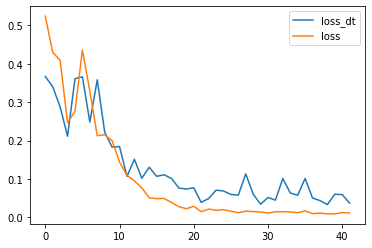

In [57]:
loss_dt = history.history['loss interior dx1']
loss = history.history['loss interior']
x = [i for i in range (len(loss_dt))]
plt.plot(x, loss_dt, label='loss_dt')
plt.plot(x, loss, label='loss')
plt.legend()
plt.show()

## Evaluation du modèle
Ici, nous évaluons le modèle (soit en chargeant le modèle des auteurs, soit en entraînant le notre). Nous examinons d'abord les paramètres fixes et faisons varier les prix des actifs . Ensuite, nous échantillonnons sur l'ensemble du domaine temps-état-paramètres pour estimer l'erreur globale. Les auteurs proposent dans leur notebook une décomposition du prix selon la partie localisation et la partie DNN. Nous reprenons et adaptons leur code afin de visulation l'erreur du modèle et surtout de l'aborder du point de vue la volatilité implicite ainsi que dans l'évaluation de la sensibilité au prix du premier sous-jacent (delta). 


### Tracés des prix d'options en faisant varier les prix des actifs




In [ ]:
DPDE_solution = model.predict(x_plot_normalised).reshape(
    nr_samples_surface_plot, nr_samples_surface_plot)

exact_solution_evaluated = [exact_solution(t=t_max, s1=s1[0], s2=s2[0], 
                                riskfree_rate=riskfree_rate_eval, 
                                volatility1=volatility1_eval, 
                                volatility2=volatility2_eval,
                                correlation=correlation_eval)
                  for s1, s2 in zip(
                      s1_plot_mesh.reshape(-1, 1), s2_plot_mesh.reshape(-1, 1))
                  
                  ]
exact_solution_evaluated = np.array(exact_solution_evaluated)
exact_solution_evaluated = exact_solution_evaluated.reshape(
    nr_samples_surface_plot, nr_samples_surface_plot)



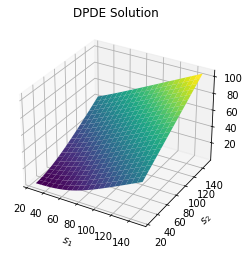

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(s1_plot_mesh, s2_plot_mesh, DPDE_solution, cmap='viridis')
ax.set_title('DPDE Solution')
ax.set_xlabel('$s_1$')
ax.set_ylabel('$s_2$')
plt.show()

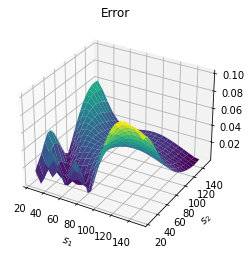

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')

error = np.abs(DPDE_solution - exact_solution_evaluated)
ax.plot_surface(s1_plot_mesh, s2_plot_mesh, error, cmap='viridis')
ax.set_title('Error')
ax.set_xlabel('$s_1$')
ax.set_ylabel('$s_2$')
plt.show()

### Estimation de l'erreur à partir de points aléatoires



In [17]:
data_samples, t_samples, s1_samples, s2_samples, riskfree_rate_samples, \
  volatility1_samples, volatility2_samples, correlation_samples = \
              get_random_points_of_interest(nr_samples_error_calculation)

In [ ]:
print('Predict {} values and measure the time:'.format(nr_samples_error_calculation))
%time DPDE_solution = model.predict(data_samples)

Predict 10000 values and measure the time:
CPU times: user 1.26 s, sys: 137 ms, total: 1.39 s
Wall time: 886 ms


In [ ]:
exact_solution_evaluated = [exact_solution(t=t, s1=s1, s2=s2, 
                                  riskfree_rate=riskfree_rate,
                                  volatility1=volatility1,
                                  volatility2=volatility2,
                                  correlation=correlation) 
            for t, s1, s2, riskfree_rate, volatility1, volatility2, correlation 
            in zip(t_samples, s1_samples, s2_samples, riskfree_rate_samples, 
                    volatility1_samples, volatility2_samples,
                    correlation_samples)]

exact_solution_evaluated = np.array(exact_solution_evaluated).reshape(-1, 1)

In [ ]:
print('Estimated MSE Error:')
print(np.sqrt(np.mean(np.square(exact_solution_evaluated - DPDE_solution))))

print('Relative Error to L2 Norm in %:')
print(np.sqrt(np.mean(np.square(exact_solution_evaluated - DPDE_solution))) 
        / np.sqrt(np.mean(np.square(exact_solution_evaluated)))*100)

print('Maximal Error:')
print(np.max(exact_solution_evaluated - DPDE_solution))

Estimated MSE Error:
0.030773506339937043
Relative Error to L2 Norm in %:
0.08530248647061686
Maximal Error:
0.19879377434168183


### Scatter plots, en faisant varier les paramètres du modèles de BS et le temps 

Les auteurs proposent d'étudier, pour différents points du domaine des paramètres, le prix du réseau de neurones contre le prix du pricer de référence. Nous pouvons en particulier relever des erreurs très élevées très loin de la monnaie.


In [ ]:
data_samples, t_samples, s1_samples, s2_samples, riskfree_rate_samples, \
  volatility1_samples, volatility2_samples, correlation_samples = \
              get_random_points_of_interest(nr_samples_scatter_plot)

In [ ]:
print('Predict {} values and measure the time:'.format(nr_samples_scatter_plot))
%time DPDE_solution = model.predict(data_samples)

Predict 1000 values and measure the time:
CPU times: user 169 ms, sys: 17.2 ms, total: 186 ms
Wall time: 125 ms


In [ ]:
exact_solution_evaluated = [exact_solution(t=t, s1=s1, s2=s2,
                                  riskfree_rate=riskfree_rate,
                                  volatility1=volatility1,
                                  volatility2=volatility2,
                                  correlation=correlation
                                  ) 
                  for t, s1, s2, riskfree_rate, volatility1, volatility2,
                      correlation 
                  in zip(t_samples, s1_samples, s2_samples, riskfree_rate_samples, 
                          volatility1_samples, volatility2_samples,
                          correlation_samples)]

exact_solution_evaluated = np.array(exact_solution_evaluated).reshape(-1,1)

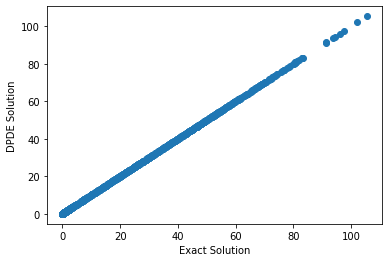

In [ ]:
plt.scatter(exact_solution_evaluated, DPDE_solution)
plt.xlabel('Exact Solution')
plt.ylabel('DPDE Solution')
plt.show()

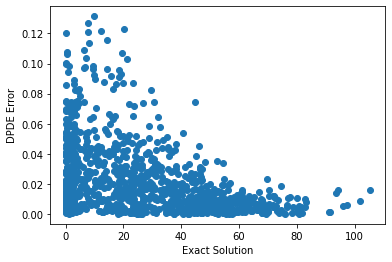

In [ ]:
plt.scatter(exact_solution_evaluated, 
            np.abs(exact_solution_evaluated - DPDE_solution))
plt.xlabel('Exact Solution')
plt.ylabel('DPDE Error')
plt.show()

# **Etudes des deltas (sensibilités)**





In [24]:
def delta_explicit(t,s1,s2,riskfree_rate, volatility1, volatility2,correlation):
  p1 = exact_solution(t, s1+6.25, s2, riskfree_rate, volatility1, volatility2,correlation)
  p2 = exact_solution(t, s1, s2, riskfree_rate, volatility1, volatility2,correlation)
  return((p1-p2)/6.25)

def delta_dnn(t,s1,s2,riskfree_rate, volatility1, volatility2,correlation, model):
  p1 = model.predict(np.array([normalise_time(t), normalise_logprice(np.log(s1+6.25)), normalise_logprice(np.log(s2)), normalise_riskfree_rate(riskfree_rate_eval), normalise_volatility(volatility1), normalise_volatility(volatility2), normalise_correlation(correlation)]).reshape(1,7))[0]
  p2 = model.predict(np.array([normalise_time(t), normalise_logprice(np.log(s1)), normalise_logprice(np.log(s2)), normalise_riskfree_rate(riskfree_rate_eval), normalise_volatility(volatility1), normalise_volatility(volatility2), normalise_correlation(correlation)]).reshape(1,7))[0]
  return((p1-p2)/6.25)


In [25]:
delta_exact_solution = [delta_explicit(t=t_max, s1=s1[0], s2=s2[0], 
                                riskfree_rate=riskfree_rate_eval, 
                                volatility1=volatility1_eval, 
                                volatility2=volatility2_eval,
                                correlation=correlation_eval)
                  for s1, s2 in zip(
                      s1_plot_mesh.reshape(-1, 1), s2_plot_mesh.reshape(-1, 1))
                  
                  ]
delta_exact_solution = np.array(delta_exact_solution)
delta_exact_solution = delta_exact_solution.reshape(
    nr_samples_surface_plot, nr_samples_surface_plot)

In [ ]:
delta_dnn_ = [delta_dnn(t=t_max, s1=s1[0], s2=s2[0], 
                                riskfree_rate=riskfree_rate_eval, 
                                volatility1=volatility1_eval, 
                                volatility2=volatility2_eval,
                                correlation=correlation_eval, 
                        model=model)
                  for s1, s2 in zip(
                      s1_plot_mesh.reshape(-1, 1), s2_plot_mesh.reshape(-1, 1))
                  
                  ]
delta_dnn_ = np.array(delta_dnn_)
delta_dnn_ = delta_dnn_.reshape(
    nr_samples_surface_plot, nr_samples_surface_plot)

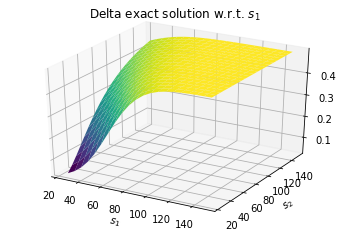

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(s1_plot_mesh, s2_plot_mesh, delta_exact_solution, cmap='viridis')
ax.set_title('Delta exact solution w.r.t. $s_1$')
ax.set_xlabel('$s_1$')
ax.set_ylabel('$s_2$')
plt.show()

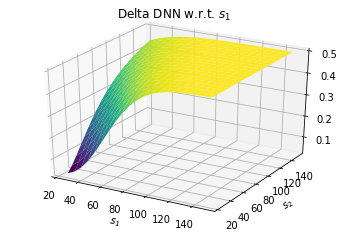

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(s1_plot_mesh, s2_plot_mesh, delta_dnn_, cmap='viridis')
ax.set_title('Delta DNN w.r.t. $s_1$')
ax.set_xlabel('$s_1$')
ax.set_ylabel('$s_2$')
plt.show()

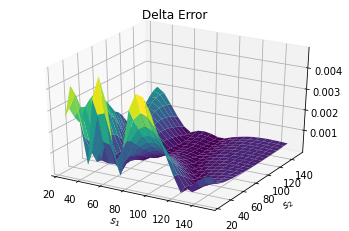

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(s1_plot_mesh, s2_plot_mesh, np.abs(delta_dnn_ - delta_exact_solution), cmap='viridis')
ax.set_title('Delta Error')
ax.set_xlabel('$s_1$')
ax.set_ylabel('$s_2$')
plt.show()

In [ ]:
print('Estimated MSE Error:')
print(np.sqrt(np.mean(np.square(delta_exact_solution - delta_dnn_))))

Estimated MSE Error:
0.0011512593955639741


In [ ]:
# Delta pour S allant de 25 à 150, comme dans le colab initial

# Delta par rapport à S_1, avec S_2 fixé
s1_plot = np.linspace(s_min_interest, s_max_interest, 10000)
delta_s = (s_max_interest-s_min_interest)/10000

delta_explicite = []
delta_DPDE = []
for i in range(9999):
  delta_explicite.append((exact_solution(t=t_max, s1=s1_plot[i+1], s2=100, 
                                riskfree_rate=riskfree_rate_eval, 
                                volatility1=volatility1_eval, 
                                volatility2=volatility2_eval,
                                correlation=correlation_eval) - 
                exact_solution(t=t_max, s1=s1_plot[i], s2=100, 
                                riskfree_rate=riskfree_rate_eval, 
                                volatility1=volatility1_eval, 
                                volatility2=volatility2_eval,
                                correlation=correlation_eval))/delta_s)
  delta_DPDE.append((model.predict(np.array([normalise_time(t_max), normalise_logprice(np.log(s1_plot[i+1])), normalise_logprice(np.log(100)), normalise_riskfree_rate(riskfree_rate_eval), normalise_volatility(volatility1_eval), normalise_volatility(volatility2_eval), normalise_correlation(correlation_eval)]).reshape(1,7))[0] 
  - model.predict(np.array([normalise_time(t_max), normalise_logprice(np.log(s1_plot[i])), normalise_logprice(np.log(100)), normalise_riskfree_rate(riskfree_rate_eval), normalise_volatility(volatility1_eval), normalise_volatility(volatility2_eval), normalise_correlation(correlation_eval)]).reshape(1,7))[0])/delta_s)



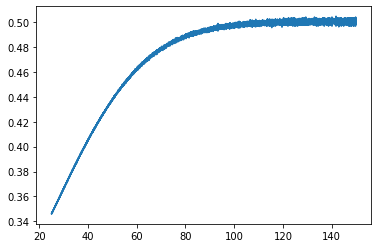

In [ ]:
#Delta DPDE
plt.plot(s1_plot[:len(s1_plot)-1],delta_DPDE,label='DNN')

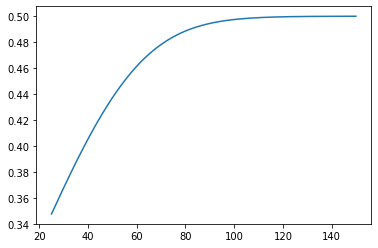

In [ ]:
#Delta Explicite
plt.plot(s1_plot[:len(s1_plot)-1],delta_explicite)

In [ ]:
#MSE Error:
np.sqrt(np.mean(np.square(np.array(delta_explicite) - np.array(delta_DPDE))))

0.05949116273694929

**Nous reproduisons alors les mêmes graphes à partir modèle "augmenté" de la dérivée de l'EDP par rapport au temps dont l'objectif est d'améliorer l'approximation des sensibilités.**

In [26]:
delta_dnn_ = [delta_dnn(t=t_max, s1=s1[0], s2=s2[0], 
                                riskfree_rate=riskfree_rate_eval, 
                                volatility1=volatility1_eval, 
                                volatility2=volatility2_eval,
                                correlation=correlation_eval, 
                                model=model_delta)
                  for s1, s2 in zip(
                      s1_plot_mesh.reshape(-1, 1), s2_plot_mesh.reshape(-1, 1))
                  
                  ]
delta_dnn_ = np.array(delta_dnn_)
delta_dnn_ = delta_dnn_.reshape(
    nr_samples_surface_plot, nr_samples_surface_plot)

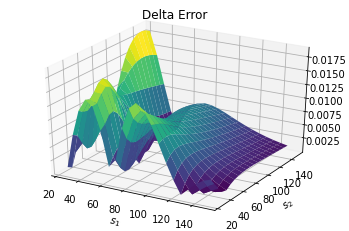

In [27]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(s1_plot_mesh, s2_plot_mesh, np.abs(delta_dnn_ - delta_exact_solution), cmap='viridis')
ax.set_title('Delta Error')
ax.set_xlabel('$s_1$')
ax.set_ylabel('$s_2$')
plt.show()

In [28]:
print('Estimated MSE Error:')
print(np.sqrt(np.mean(np.square(delta_exact_solution - delta_dnn_))))

Estimated MSE Error:
0.007396633213755296


In [30]:
# Delta pour S allant de 25 à 150, comme dans le colab initial

# Delta par rapport à S_1, avec S_2 fixé
s1_plot = np.linspace(s_min_interest, s_max_interest, 10000)
delta_s = (s_max_interest-s_min_interest)/10000

delta_explicite = []
delta_DPDE = []
for i in range(9999):
  delta_explicite.append((exact_solution(t=t_max, s1=s1_plot[i+1], s2=100, 
                                riskfree_rate=riskfree_rate_eval, 
                                volatility1=volatility1_eval, 
                                volatility2=volatility2_eval,
                                correlation=correlation_eval) - 
                exact_solution(t=t_max, s1=s1_plot[i], s2=100, 
                                riskfree_rate=riskfree_rate_eval, 
                                volatility1=volatility1_eval, 
                                volatility2=volatility2_eval,
                                correlation=correlation_eval))/delta_s)
  delta_DPDE.append((model_delta.predict(np.array([normalise_time(t_max), normalise_logprice(np.log(s1_plot[i+1])), normalise_logprice(np.log(100)), normalise_riskfree_rate(riskfree_rate_eval), normalise_volatility(volatility1_eval), normalise_volatility(volatility2_eval), normalise_correlation(correlation_eval)]).reshape(1,7))[0] 
  - model_delta.predict(np.array([normalise_time(t_max), normalise_logprice(np.log(s1_plot[i])), normalise_logprice(np.log(100)), normalise_riskfree_rate(riskfree_rate_eval), normalise_volatility(volatility1_eval), normalise_volatility(volatility2_eval), normalise_correlation(correlation_eval)]).reshape(1,7))[0])/delta_s)



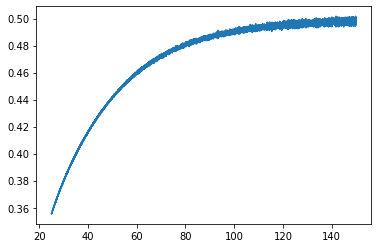

In [31]:
#Delta DPDE
plt.plot(s1_plot[:len(s1_plot)-1],delta_DPDE,label='DNN')

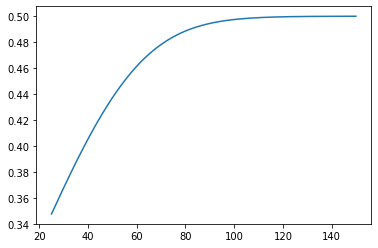

In [32]:
#Delta Explicite
plt.plot(s1_plot[:len(s1_plot)-1],delta_explicite)

In [33]:
#MSE Error:
np.sqrt(np.mean(np.square(np.array(delta_explicite) - np.array(delta_DPDE))))

0.05527541854498272

# **Using Implied Volatility to evaluate the method**

In [ ]:
# Using the generalization of Implied Vol for 2 or more assets

import scipy.stats as stats

def BS_Call(S,T,r,sigma,K):
  d_1 = (np.log(S/K) + (r+sigma**2/2)*T)/(sigma*np.sqrt(T))
  d_2 = d_1 - sigma * np.sqrt(T)
  return(S*stats.norm.cdf(d_1)-K*np.exp(-r*T)*stats.norm.cdf(d_2))

def BS_Vega_Call(S,K,T,r,sigma):
  d_1 = (np.log(S/K) + (r+sigma**2/2)*T)/(sigma*np.sqrt(T))
  return S * np.sqrt(T)*stats.norm.pdf(d_1)

# To compute the implied_volatility, we use Newton-Raphson method
def Implied_Volatility(Price,S,K,r,T):
  try:
    Implied_vol = 0.5
    Target = 10**(-4)
    Keep_computing = True
    while Keep_computing:
      aux = Implied_vol
      Implied_vol = Implied_vol - (BS_Call(S,T,r,Implied_vol,K) - Price)/BS_Vega_Call(S,K,T,r,Implied_vol)
      if abs(BS_Call(S,T,r,Implied_vol,K) - Price) < Target:
        Keep_computing = False
    return(Implied_vol)
  except:
    return(Implied_Volatility_bis(Price,S,K,r,T))

def Implied_Volatility_bis(Price,S,K,r,T):
  Implied_vol = 0.9
  for i in range(2,8):
    if BS_Call(S,T,r,Implied_vol,K) - Price > 0:
      while BS_Call(S,T,r,Implied_vol,K) - Price > 0:
        Implied_vol = Implied_vol - 10**(-i)
    else:
      while BS_Call(S,T,r,Implied_vol,K) - Price < 0:
        Implied_vol = Implied_vol + 10**(-i)
  if Implied_vol < 0.05:
    print(Implied_vol,Price,BS_Call(S,T,r,Implied_vol,K),S,K,r,T)
  return(Implied_vol)


In [ ]:
Implied_Volatility_Explicit = [Implied_Volatility_bis(Price=exact_solution(t=t_max, s1=s1[0], s2=s2[0], 
                                riskfree_rate=riskfree_rate_eval, 
                                volatility1=volatility1_eval, 
                                volatility2=volatility2_eval,
                                correlation=correlation_eval),S=0.5*(s1[0]+s2[0]),K=100,r=riskfree_rate_eval,T=4)
                  for s1, s2 in zip(
                      s1_plot_mesh.reshape(-1, 1), s2_plot_mesh.reshape(-1, 1))]

Implied_Volatility_Explicit = np.array(Implied_Volatility_Explicit)
Implied_Volatility_Explicit = Implied_Volatility_Explicit.reshape(
    nr_samples_surface_plot, nr_samples_surface_plot)



In [ ]:
Implied_Volatility_DPDE = [Implied_Volatility_bis(Price=
                                              model.predict(np.array([normalise_time(t_max), normalise_logprice(np.log(s1[0])), normalise_logprice(np.log(s2[0])), normalise_riskfree_rate(riskfree_rate_eval), normalise_volatility(volatility1_eval), normalise_volatility(volatility2_eval), normalise_correlation(correlation_eval)]).reshape(1,7))[0][0]
                                              ,S=0.5*(s1[0]+s2[0]),K=100,r=riskfree_rate_eval,T=4)
                  for s1, s2 in zip(
                      s1_plot_mesh.reshape(-1, 1), s2_plot_mesh.reshape(-1, 1))]

Implied_Volatility_DPDE = np.array(Implied_Volatility_DPDE)
Implied_Volatility_DPDE = Implied_Volatility_DPDE.reshape(
    nr_samples_surface_plot, nr_samples_surface_plot)

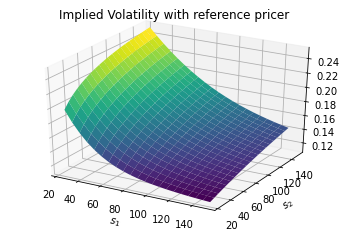

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(s1_plot_mesh, s2_plot_mesh, Implied_Volatility_Explicit, cmap='viridis')
ax.set_title('Implied Volatility with reference pricer')
ax.set_xlabel('$s_1$')
ax.set_ylabel('$s_2$')
plt.show()

In [ ]:
Implied_Volatility_bis(model.predict(np.array([normalise_time(t_max), normalise_logprice(np.log(120)), normalise_logprice(np.log(140)), normalise_riskfree_rate(0.2), normalise_volatility(volatility1_eval), normalise_volatility(volatility2_eval), normalise_correlation(correlation_eval)]).reshape(1,7))[0],
            S=0.5*(287.5),K=100,r=riskfree_rate_eval,T=4)           

9.999999935796384e-08 [85.05615] 98.81710358827785 143.75 100 0.2 4


9.999999935796384e-08

In [ ]:
model.predict(np.array([normalise_time(t_max), normalise_logprice(np.log(120)), normalise_logprice(np.log(140)), normalise_riskfree_rate(0.2), normalise_volatility(volatility1_eval), normalise_volatility(volatility2_eval), normalise_correlation(correlation_eval)]).reshape(1,7))[0][0]

85.05615

In [ ]:
exact_solution(t=t_max, s1=120, s2=140, 
                                riskfree_rate=riskfree_rate_eval, 
                                volatility1=volatility1_eval, 
                                volatility2=volatility2_eval,
                                correlation=correlation_eval)

85.0688038670782

In [ ]:
Implied_Volatility_bis(exact_solution(t=t_max, s1=120, s2=140, 
                                riskfree_rate=riskfree_rate_eval, 
                                volatility1=volatility1_eval, 
                                volatility2=volatility2_eval,
                                correlation=correlation_eval),S=0.5*(260),K=100,r=riskfree_rate_eval,T=4)

0.1542218999999995

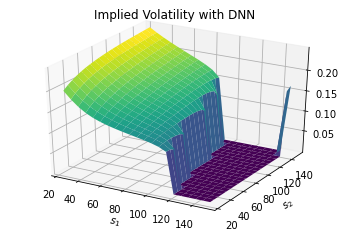

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(s1_plot_mesh, s2_plot_mesh, Implied_Volatility_DPDE, cmap='viridis')
ax.set_title('Implied Volatility with DNN')
ax.set_xlabel('$s_1$')
ax.set_ylabel('$s_2$')
plt.show()

Pour comprendre le soucis, on plot Black-Scholes en fonction de sigma pour S1 et S2 tels que S1 + S2 > 140.

Text(0.5, 1.0, 'Black-Scholes price w.r.t $\\sigma$')

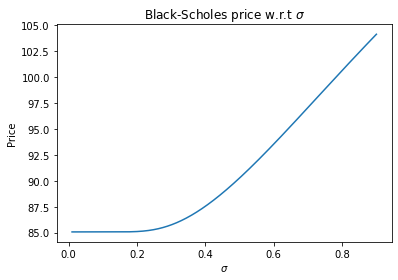

In [ ]:
sigma = np.linspace(0.01,0.9,10000)
y = BS_Call(130,4,0.2,sigma,100)
plt.plot(sigma,y)
plt.xlabel("$\sigma$")
plt.ylabel("Price")
plt.title("Black-Scholes price w.r.t $\sigma$")

In [ ]:
print('Minimum Black-Scholes (with $\sigma$ = 0.01 ' + str(BS_Call(130,4,0.2,0.01,100)))
print(exact_solution(t=t_max, s1=120, s2=140, 
                                riskfree_rate=riskfree_rate_eval, 
                                volatility1=volatility1_eval, 
                                volatility2=volatility2_eval,
                                correlation=correlation_eval))
print(model.predict(np.array([normalise_time(t_max), normalise_logprice(np.log(120)), normalise_logprice(np.log(140)), normalise_riskfree_rate(0.2), normalise_volatility(volatility1_eval), normalise_volatility(volatility2_eval), normalise_correlation(correlation_eval)]).reshape(1,7))[0][0])


Minimum Black-Scholes (with $\sigma$ = 0.01 85.06710358827785
85.0688038670782
85.05615
